In [1]:
import numpy as np
import matplotlib.pyplot as plt

from model_fitting import least_sq_fit

In [2]:
help(least_sq_fit)

Help on function least_sq_fit in module model_fitting:

least_sq_fit(model, xdata, ydata, init_params, show_history=False, max_iterations=5000, tolerance=1e-06, step_size=0.001, learn_rate=0.001)
    Least square fitter that uses the central difference gradient descent algorithm.

    Parameters
    --------
    - model:  function
        Function f(x, params) that returns the expected ydata for given xdata and params.
    - xdata:  np.ndarray
        Independent variable data
    - ydata:  np.ndarray
        Dependent variable data
    - init_params: np.ndarray
        Initial guess for the model parameters

    - show_history: Bool
        Choice to return a numpy array containing the sum of square errors at each step.
    - max_iterations: int
        Maximum number of iterations before the function outputs the parameters,
        even if the tolerance has not been achieved. Defaults to 5000.
    - tolerance: float
        Stopping tolerance based on magnitude/norm of the gradient, 

In [3]:
def quadratic(x, a, b, c):
    return a*x**2 + b*x + c

def gaussian(x, a, b, c):
    return a * np.exp(-(x-b)**2/(2*c**2))

In [4]:
xdata = np.arange(-15, 25, 0.5)
yquad = quadratic(xdata, 0.5, 2, -2)
ygaus = gaussian(xdata, 200, 1, -3)

In [8]:
quad_params, qhist = least_sq_fit(quadratic, xdata, yquad, init_params = np.array([5, 5, 0]), show_history=True, step_size=.9)

print(quad_params, qhist)

gauss_params, ghist = least_sq_fit(gaussian, xdata, ygaus, init_params = np.array([100, 1, 1]), show_history=True, step_size=.9)

print(gauss_params, ghist)

[5. 5. 0.] [86550541.625]
[100.   1.   1.] [270598.29095034]


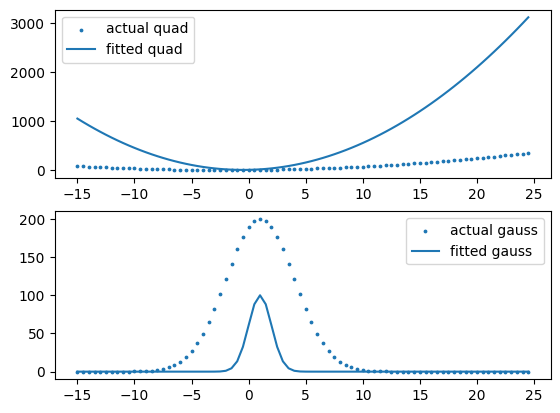

In [9]:
plt.subplots(2, 1)

plt.subplot(2, 1, 1)
plt.scatter(xdata, yquad, s = 3, label = 'actual quad')
plt.plot(xdata, quadratic(xdata, *quad_params), label = 'fitted quad')
plt.legend()

plt.subplot(2, 1, 2)
plt.scatter(xdata, ygaus, s = 3, label = 'actual gauss')
plt.plot(xdata, gaussian(xdata, *gauss_params), label = 'fitted gauss')
plt.legend()

In [10]:
import numpy as np

def grad_descent(model, xdata, ydata, params, step_size):
    """
    Calculates the gradient of the sum of squared errors (SSE) 
    using the central difference method.
    """
    grad = np.zeros_like(params)

    for i in range(len(params)):
        # adaptive step size per parameter
        h = max(step_size * (abs(params[i]) + 1.0), 1e-8)
        dparams = np.zeros_like(params)
        dparams[i] = h

        # forward and backward perturbations
        y_plus  = model(xdata, *(params + dparams))
        y_minus = model(xdata, *(params - dparams))

        # compute SSE
        sq_err_plus  = np.sum((ydata - y_plus )**2)
        sq_err_minus = np.sum((ydata - y_minus)**2)

        # central difference on the error function
        grad[i] = (sq_err_plus - sq_err_minus) / (2 * h)

    return grad


def least_sq_fit(model, xdata, ydata, init_params, 
                 show_history=False, max_iterations=5000, 
                 tolerance=1e-6, step_size=1e-3, 
                 learn_rate=1e-2, backtrack=0.5):
    """
    Least square fitter that uses central difference gradient descent
    with adaptive learning rate (backtracking line search).
    """
    assert isinstance(init_params, np.ndarray), "init_params must be a numpy array"

    history = []
    params = init_params.copy()

    for it in range(max_iterations):
        # current SSE
        y_predicted = model(xdata, *params)
        residuals   = ydata - y_predicted
        sum_sq_errs = np.sum(residuals**2)
        history.append(sum_sq_errs)

        # compute gradient
        grad = grad_descent(model, xdata, ydata, params, step_size)

        # backtracking line search
        lr = learn_rate
        while True:
            new_params = params - lr * grad
            new_pred   = model(xdata, *new_params)
            new_sse    = np.sum((ydata - new_pred)**2)

            if new_sse < sum_sq_errs:  # improvement
                params = new_params
                break
            else:
                lr *= backtrack   # shrink step size
                if lr < 1e-12:    # prevent infinite loop
                    break

        # stopping condition
        if np.linalg.norm(grad) < tolerance:
            print(f"Converged at iteration {it}")
            break

    if show_history:
        return params, np.array(history)
    else:
        return params





In [11]:
# --- Example test ---

# quadratic: y = ax^2 + bx + c
def quad_model(x, a, b, c):
    return a*x**2 + b*x + c

# generate noisy data
x = np.linspace(-5, 5, 100)
y_true = 2*x**2 - 3*x + 5
y_noisy = y_true + 0.5*np.random.randn(len(x))

init_params = np.array([1.0, 1.0, 1.0])  # initial guess
params, history = least_sq_fit(
    quad_model, x, y_noisy, init_params, 
    show_history=True, learn_rate=1e-2
)

print("Fitted params:", params)
print("First 10 SSE values:", history[:10])

Fitted params: [ 2.00347698 -3.00823673  4.94859933]
First 10 SSE values: [35080.12346959 33429.91448272 32767.28937258  7409.38751511
  3064.60513496   618.61522288   601.20267945   591.32860845
   582.39503218   574.21656826]


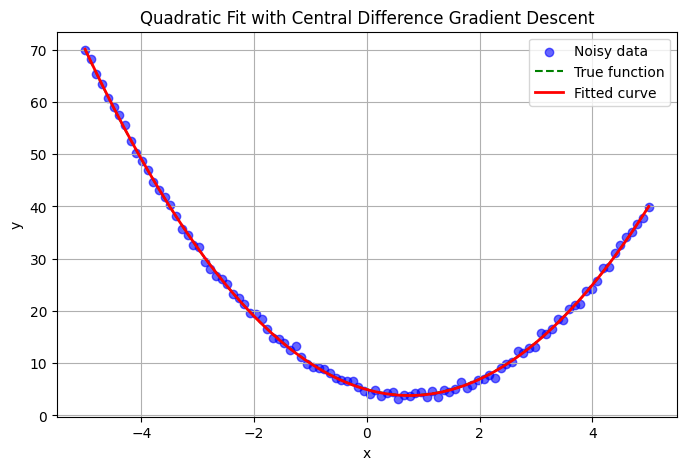

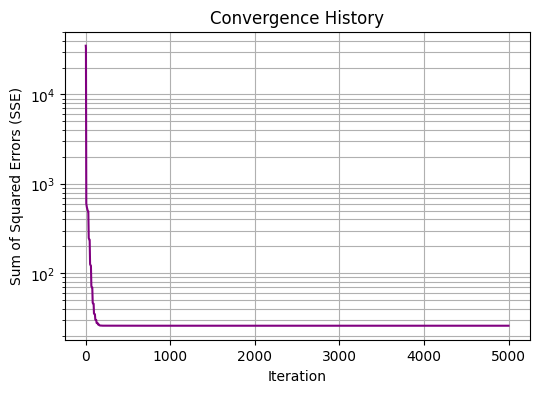

In [12]:
import matplotlib.pyplot as plt

# Plot the noisy data and fitted curve
plt.figure(figsize=(8,5))
plt.scatter(x, y_noisy, label="Noisy data", color="blue", alpha=0.6)
plt.plot(x, y_true, label="True function", color="green", linestyle="--")
plt.plot(x, quad_model(x, *params), label="Fitted curve", color="red", linewidth=2)
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Quadratic Fit with Central Difference Gradient Descent")
plt.grid(True)
plt.show()

# Optional: Plot SSE convergence
plt.figure(figsize=(6,4))
plt.semilogy(history, color="purple")
plt.xlabel("Iteration")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Convergence History")
plt.grid(True, which="both")
plt.show()